In [1]:
import numpy as np
import tensorflow as tf
import gzip
import pickle
import sys
import copy
import os.path
import pdb
import re
from run_split import SplitMnistGenerator
from alg.cla_models_multihead import MFVI_NN, Vanilla_NN
from alg.HIBP_BNN_multihead import HIBP_BNN
from alg.utils import get_scores, concatenate_results
from alg.vcl import run_vcl
from copy import deepcopy

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

# Weight pruning

In [2]:
class HIBP_BNN_prune(HIBP_BNN):
    def __init__(self, alphas, input_size, hidden_size, 
                 output_size, training_size, num_ibp_samples=10,
                 no_train_samples=10, no_pred_samples=100, 
                 prev_means=None, prev_log_variances=None,
                 prev_betas=None, learning_rate=0.0001,
                 learning_rate_decay=0.87,
                 prior_mean=0, prior_var=1, alpha0=5., 
                 beta0=1., lambda_1=1., lambda_2=1.,
                 tensorboard_dir='logs', name='hibp_wp', 
                 tb_logging=True,
                 output_tb_gradients=True, beta_1=1.0, beta_2=1.0, 
                 beta_3=1.0, use_local_reparam=False, implicit_beta=True):

        super(HIBP_BNN_prune, self).__init__(alphas=alphas, 
                input_size=input_size, hidden_size=hidden_size, 
                output_size=output_size, 
                training_size=training_size, num_ibp_samples=num_ibp_samples,
                 no_train_samples=no_train_samples, no_pred_samples=no_pred_samples, 
                 prev_means=prev_means, prev_log_variances=prev_log_variances,
                 prev_betas=prev_betas, learning_rate=learning_rate,
                 learning_rate_decay=learning_rate_decay,
                 prior_mean=prior_mean, prior_var=prior_var, alpha0=alpha0, 
                 beta0=beta0, lambda_1=lambda_1, lambda_2=lambda_2,
                 tensorboard_dir=tensorboard_dir, name=name, 
                 tb_logging=tb_logging,
                 output_tb_gradients=output_tb_gradients, beta_1=beta_1, 
                 beta_2=beta_2, beta_3=beta_3, use_local_reparam=use_local_reparam,
                 implicit_beta=implicit_beta)


    def prune_weights(self, X_test, Y_test, task_id):
        """ Performs weight pruning.
        
        Z is at a data level doesn't make sense to introduce this intot he mask over weights which get zeroed 
        out. Simlpy running the accuracy over the graph will entail that Z is incorporated into the 
        matrix math for the prediction calculations.
        
        Args:
            X_test: numpy array
            Y_test: numpy array
            task_id: int
        :return: cutoffs, accs via naive pruning, accs via snr pruning,
        weight values, sigma values of network
        """

        def reset_weights(pr_mus, pr_sigmas, _mus, _sigmas):
            """ Reset weights of graph to original values
            Args:
                pr_mus: list of tf variables which have been pruned
                pr_sigmas: list of tf variables which have been pruned
                _mus: list of cached mus in numpy
                _sigmas: list of cached sigmas in numpy
            """

            for v, _v in zip(pr_mus, _mus):
                self.sess.run(tf.assign(v, tf.cast(_v, v.dtype)))

            for v, _v in zip(pr_sigmas, _sigmas):
                self.sess.run(tf.assign(v, tf.cast(_v, v.dtype)))

        def pruning(remove_pct, weightvalues, sigmavalues,
                    weights, sigmas, uncert_pruning=True):
            """ Performs weight pruning experiment
            Args:
                weightvalues: np array of weights
                sigmavalues: np array of sigmas
                weights: list of tf weight variable
                new_weights: list of new tf weight variables which wil
                sigmas: list of tf sigma variables
                uncert_pruning: bool pruning by snr
            """
            if uncert_pruning:
                sorted_STN = np.sort(np.abs(weightvalues) / sigmavalues)
                
            else:
                sorted_STN = np.sort(np.abs(weightvalues))
            cutoff = sorted_STN[int(remove_pct * len(sorted_STN))]
            
            # Weights, biases and head weights
            for v, s in zip(weights, sigmas):
                if uncert_pruning:
                    snr = tf.abs(v) / tf.exp(0.5*s)
                    mask = tf.greater_equal(snr, cutoff)
                else:
                    mask = tf.greater_equal(tf.abs(v), cutoff)
                self.sess.run(tf.assign(v, tf.multiply(v, tf.cast(mask, v.dtype))))
                #self.sess.run(tf.assign(s, np.multiply(self.sess.run(s), mask)))  # also apply zero std to weight!!!
                
            accs = []
            for _ in range(10):
                accs.append(self.sess.run(self.acc, {self.x: X_test,
                                                     self.y: Y_test,
                                                     self.task_idx: task_id,
                                                     self.temp: self.lambda_1,
                                                     self.training: False}))
            print("%.2f, %s" % (np.sum(sorted_STN < cutoff) / len(sorted_STN), np.mean(accs)))
            return np.mean(accs)

        # get weights
        weights = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=tf.get_variable_scope().name)
        
        # Get weights from network
        mus_w = []
        mus_b = []
        sigmas_w = []
        sigmas_b = []
        mus_h = [] # weights and biases
        sigmas_h = [] # weights and biases
        for v in weights:
            if re.match("^([w])(_mu_)([0-9]+)(:0)$", v.name):
                mus_w.append(v)
            elif re.match("^([w])(_sigma_)([0-9]+)(:0)$", v.name):
                sigmas_w.append(v)
            elif re.match("^([b])(_mu_)([0-9]+)(:0)$", v.name):
                mus_b.append(v)
            elif re.match("^([b])(_sigma_)([0-9]+)(:0)$", v.name):
                sigmas_b.append(v)
            elif re.match("^([wb])(_mu_h_)([0-9]+)(:0)$", v.name):
                mus_h.append(v)
            elif re.match("^([wb])(_sigma_h_)([0-9]+)(:0)$", v.name):
                sigmas_h.append(v)
            else:
                print("Un-matched: {}".format(v.name))
                
        acc = self.sess.run(self.acc, {self.x: X_test,
                                    self.y: Y_test,
                                    self.task_idx: task_id,
                                    self.temp: self.lambda_1,
                                    self.training: False}) # z mask for each layer in a list, each Z \in dout
        print("test acc: {}".format(acc))
        # cache network weights of resetting the network
        _mus_w = [self.sess.run(w) for w in mus_w]
        _sigmas_w = [self.sess.run(w) for w in sigmas_w]
        _mus_b = [self.sess.run(w) for w in mus_b]
        _sigmas_b = [self.sess.run(w) for w in sigmas_b]
        _mus_h = [self.sess.run(w) for w in mus_h]
        _sigmas_h = [self.sess.run(w) for w in sigmas_h]
        
        weightvalues = np.hstack(np.array([self.sess.run(w).flatten() for w in mus_w + mus_b + mus_h]))
        sigmavalues = np.hstack(np.array([self.sess.run(tf.exp(0.5*s)).flatten() for s in sigmas_w + sigmas_b + sigmas_h]))
    
        xs = np.append(0.05 * np.array(range(20)), np.array([0.98, 0.99, 0.999]))
        ya_ibp = []
        for pct in xs:
            ya_ibp.append(pruning(pct, weightvalues, sigmavalues, mus_w + mus_b + mus_h,
                              sigmas_w + sigmas_b + sigmas_h, uncert_pruning=False))

        # reset etc.
        reset_weights(mus_w, sigmas_w, _mus_w, _sigmas_w)
        reset_weights(mus_b, sigmas_b, _mus_b, _sigmas_b)
        reset_weights(mus_h, sigmas_h, _mus_h, _sigmas_h)
        yb_ibp = []
        for pct in xs:
            yb_ibp.append(pruning(pct, weightvalues, sigmavalues, mus_w + mus_b + mus_h,
                                  sigmas_w + sigmas_b + sigmas_h, uncert_pruning=True))
            
        reset_weights(mus_w, sigmas_w, _mus_w, _sigmas_w)
        reset_weights(mus_b, sigmas_b, _mus_b, _sigmas_b)
        reset_weights(mus_h, sigmas_h, _mus_h, _sigmas_h)
        
        #return xs, ya, yb, ya_ibp, yb_ibp
        return xs, ya_ibp, yb_ibp

# Multiclass CLF Weight Pruning

In [3]:
class MnistGenerator():
    def __init__(self, max_iter=10):
        with gzip.open('data/mnist.pkl.gz', 'rb') as f:
            train_set, valid_set, test_set = pickle.load(f, encoding='latin1')

        self.X_train = np.vstack((train_set[0], valid_set[0]))
        self.Y_train = np.hstack((train_set[1], valid_set[1]))
        self.X_test = test_set[0]
        self.Y_test = test_set[1]
        self.max_iter = max_iter
        self.cur_iter = 0

    def get_dims(self):
        # Get data input and output dimensions
        return self.X_train.shape[1], 10

    def task(self):
        # Retrieve train data
        x_train = deepcopy(self.X_train)
        y_train = np.eye(10)[self.Y_train]

        # Retrieve test data
        x_test = deepcopy(self.X_test)
        y_test = np.eye(10)[self.Y_test]
        
        return x_train, y_train, x_test, y_test

In [7]:
hidden_size = [400, 400]
batch_size = 256
no_epochs = 600
runs = 1
seeds = [1,2,3,4,5]
np.random.seed(1)
xs = np.append(0.05 * np.array(range(20)), np.array([0.98, 0.99, 0.999]))
ya_ibp_all = np.zeros((runs, len(xs)))
yb_ibp_all = np.zeros((runs, len(xs)))

for i in range(runs):
    tf.set_random_seed(seeds[i])
    coreset_size = 0
    data_gen = MnistGenerator()
    single_head=False
    in_dim, out_dim = data_gen.get_dims()
    x_testsets, y_testsets = [], []
    task_id=0

    tf.reset_default_graph()  
    x_train, y_train, x_test, y_test = data_gen.task()
    x_testsets.append(x_test)
    y_testsets.append(y_test)

    # Set the readout head to train
    head = 0 if single_head else task_id
    bsize = x_train.shape[0] if (batch_size is None) else batch_size

    # Train network with maximum likelihood to initialize first model
    if task_id == 0:
        ml_model = Vanilla_NN(in_dim, hidden_size, out_dim, x_train.shape[0])
        ml_model.train(x_train, y_train, task_id, 30, bsize)
        mf_weights = ml_model.get_weights()
        mf_variances = None
        mf_betas = None
        ml_model.close_session()

    # Train on non-coreset data
    model = HIBP_BNN_prune(alphas=[1.]*len(hidden_size), 
                           input_size=in_dim, 
                           hidden_size=hidden_size, 
                           output_size=out_dim, 
                           training_size=x_train.shape[0], 
                           no_pred_samples=100,
                           num_ibp_samples=10, prev_means=mf_weights, 
                           prev_log_variances=mf_variances, 
                           prev_betas=mf_betas,
                           learning_rate=0.001, learning_rate_decay=0.87,
                           prior_mean=0.0, prior_var=0.1,
                           alpha0=2.0, beta0=1.0,
                           lambda_1=1.0, lambda_2=1.0,
                           tensorboard_dir='logs_wp',
                           name='ibp_wp_mnist_new_run{0}'.format(i),
                           use_local_reparam=False, implicit_beta=True)
    model.create_model()
    #mf_model.restore(os.path.join("logs", "graph_{}_task{}".format('ibp_wp_mnist', 0)))
    model.train(x_train, y_train, head, no_epochs, bsize)

    xs, ya_ibp, yb_ibp  = model.prune_weights(x_test, y_test, head)
    ya_ibp_all[i, :] = ya_ibp
    yb_ibp_all[i, :] = yb_ibp

    model.close_session()

Epoch: 0001 cost= 0.258021302
Epoch: 0006 cost= 0.017882407
Epoch: 0011 cost= 0.008703025
Epoch: 0016 cost= 0.005693266
Epoch: 0021 cost= 0.003098166
Epoch: 0026 cost= 0.007468683
Z: (1, ?, 400)
Z: (1, ?, 400)
Epoch: 0001 train cost= 12.756950589
Epoch: 0006 train cost= 7.260589273
Epoch: 0011 train cost= 4.057053849
Epoch: 0016 train cost= 2.027989602
Epoch: 0021 train cost= 0.956064029
Epoch: 0026 train cost= 0.554142064
Epoch: 0031 train cost= 0.475193516
Epoch: 0036 train cost= 0.441342639
Epoch: 0041 train cost= 0.428163951
Epoch: 0046 train cost= 0.419542998
Epoch: 0051 train cost= 0.411797653


KeyboardInterrupt: 

In [ ]:
#plt.plot(xs, ya, label='$|\mu|$')
#plt.plot(xs, yb, label='snr')
plt.plot(xs, ya_ibp, label='ibp $|\mu|$')
plt.plot(xs, yb_ibp, label='ibp snr')
plt.xlabel('cut-off')
plt.ylabel('acc')
plt.legend()
plt.show()

# No IBP

In [6]:
class MFVI_NN_prune(MFVI_NN):
    def __init__(self, input_size, hidden_size, output_size, training_size, 
        no_train_samples=10, no_pred_samples=100, prev_means=None, prev_log_variances=None, learning_rate=0.001, 
        prior_mean=0, prior_var=1):

        super(MFVI_NN_prune, self).__init__(input_size, hidden_size, output_size, training_size, 
        no_train_samples, no_pred_samples, prev_means, prev_log_variances, learning_rate, 
        prior_mean, prior_var)


    def prune_weights(self, X_test, Y_test, task_id):
        """ Performs weight pruning.
        
        Z is at a data level doesn't make sense to introduce this intot he mask over weights which get zeroed 
        out. Simlpy running the accuracy over the graph will entail that Z is incorporated into the 
        matrix math for the prediction calculations.
        
        Args:
            X_test: numpy array
            Y_test: numpy array
            task_id: int
        :return: cutoffs, accs via naive pruning, accs via snr pruning,
        weight values, sigma values of network
        """

        def reset_weights(pr_mus, pr_sigmas, _mus, _sigmas):
            """ Reset weights of graph to original values
            Args:
                pr_mus: list of tf variables which have been pruned
                pr_sigmas: list of tf variables which have been pruned
                _mus: list of cached mus in numpy
                _sigmas: list of cached sigmas in numpy
            """

            for v, _v in zip(pr_mus, _mus):
                self.sess.run(tf.assign(v, tf.cast(_v, v.dtype)))

            for v, _v in zip(pr_sigmas, _sigmas):
                self.sess.run(tf.assign(v, tf.cast(_v, v.dtype)))

        def pruning(remove_pct, weightvalues, sigmavalues,
                    weights, sigmas, uncert_pruning=True):
            """ Performs weight pruning experiment
            Args:
                weightvalues: np array of weights
                sigmavalues: np array of sigmas
                weights: list of tf weight variable
                sigmas: list of tf sigma variables
                uncert_pruning: bool pruning by snr
            """
            if uncert_pruning:
                sorted_STN = np.sort(np.abs(weightvalues) / sigmavalues)
                
            else:
                sorted_STN = np.sort(np.abs(weightvalues))
            cutoff = sorted_STN[int(remove_pct * len(sorted_STN))]
            
            # Weights, biases and head weights
            for v, s in zip(weights, sigmas):
                if uncert_pruning:
                    snr = tf.abs(v) / tf.exp(0.5*s)
                    mask = tf.greater_equal(snr, cutoff)
                else:
                    mask = tf.greater_equal(tf.abs(v), cutoff)
                self.sess.run(tf.assign(v, tf.multiply(v, tf.cast(mask, v.dtype))))
                
            accs = []
            for _ in range(10):
                accs.append(self.sess.run(self.acc, {self.x: X_test,
                                                     self.y: Y_test,
                                                     self.task_idx: task_id}))
            print("%.2f, %s" % (np.sum(sorted_STN < cutoff) / len(sorted_STN), np.mean(accs)))
            return np.mean(accs)

        # get weights
        weights = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=tf.get_variable_scope().name)
        
        # Get weights from network
        mus_w = []
        mus_b = []
        sigmas_w = []
        sigmas_b = []
        mus_h = [] # weights and biases
        sigmas_h = [] # weights and biases
        for v in weights:
            if re.match("^([w])(_mu_)([0-9]+)(:0)$", v.name):
                mus_w.append(v)
            elif re.match("^([w])(_sigma_)([0-9]+)(:0)$", v.name):
                sigmas_w.append(v)
            elif re.match("^([b])(_mu_)([0-9]+)(:0)$", v.name):
                mus_b.append(v)
            elif re.match("^([b])(_sigma_)([0-9]+)(:0)$", v.name):
                sigmas_b.append(v)
            elif re.match("^([wb])(_mu_h_)([0-9]+)(:0)$", v.name):
                mus_h.append(v)
            elif re.match("^([wb])(_sigma_h_)([0-9]+)(:0)$", v.name):
                sigmas_h.append(v)
            else:
                print("Un-matched: {}".format(v.name))
                
        # cache network weights of resetting the network
        _mus_w = [self.sess.run(w) for w in mus_w]
        _sigmas_w = [self.sess.run(w) for w in sigmas_w]
        _mus_b = [self.sess.run(w) for w in mus_b]
        _sigmas_b = [self.sess.run(w) for w in sigmas_b]
        _mus_h = [self.sess.run(w) for w in mus_h]
        _sigmas_h = [self.sess.run(w) for w in sigmas_h]
        
        weightvalues = np.hstack(np.array([self.sess.run(w).flatten() for w in mus_w + mus_b + mus_h]))
        sigmavalues = np.hstack(np.array([self.sess.run(tf.exp(0.5*s)).flatten() for s in sigmas_w + sigmas_b + sigmas_h]))
    
        xs = np.append(0.05 * np.array(range(20)), np.array([0.98, 0.99, 0.999]))
        # pruning
        ya = []
        for pct in xs:
            ya.append(pruning(pct, weightvalues, sigmavalues, mus_w + mus_b + mus_h,
                              sigmas_w + sigmas_b + sigmas_h, uncert_pruning=False))

        # reset etc.
        reset_weights(mus_w, sigmas_w, _mus_w, _sigmas_w)
        reset_weights(mus_b, sigmas_b, _mus_b, _sigmas_b)
        reset_weights(mus_h, sigmas_h, _mus_h, _sigmas_h)
        yb = []
        for pct in xs:
            yb.append(pruning(pct, weightvalues, sigmavalues, mus_w + mus_b + mus_h,
                                  sigmas_w + sigmas_b + sigmas_h, uncert_pruning=True))
            
        reset_weights(mus_w, sigmas_w, _mus_w, _sigmas_w)
        reset_weights(mus_b, sigmas_b, _mus_b, _sigmas_b)
        reset_weights(mus_h, sigmas_h, _mus_h, _sigmas_h)
        
        return xs, ya, yb

In [7]:
hidden_size = [100]
batch_size = 128
no_epochs = 600
runs = 5
seeds = [10,11,12,13,14]
xs = np.append(0.05 * np.array(range(20)), np.array([0.98, 0.99, 0.999]))
ya_all = np.zeros((runs, len(xs)))
yb_all = np.zeros((runs, len(xs)))

for i in range(runs):
    tf.set_random_seed(seeds[i])
    np.random.seed(1)
    coreset_size = 0
    data_gen = MnistGenerator()
    single_head=False
    in_dim, out_dim = data_gen.get_dims()
    task_id=0

    tf.reset_default_graph()  
    x_train, y_train, x_test, y_test = data_gen.task()

    # Set the readout head to train
    head = 0 if single_head else task_id
    bsize = x_train.shape[0] if (batch_size is None) else batch_size

    # Train network with maximum likelihood to initialize first model
    if task_id == 0:
        ml_model = Vanilla_NN(in_dim, hidden_size, out_dim, x_train.shape[0])
        ml_model.train(x_train, y_train, task_id, 100, bsize)
        mf_weights = ml_model.get_weights()
        mf_variances = None
        ml_model.close_session()

    # Train on non-coreset data
    mf_model = MFVI_NN_prune(in_dim, hidden_size, out_dim, x_train.shape[0], prev_means=mf_weights, 
                             prev_log_variances=mf_variances)

    mf_model.train(x_train, y_train, head, no_epochs, bsize)

    xs, ya, yb = mf_model.prune_weights(x_test, y_test, head)
    ya_all[i, :] = ya
    yb_all[i, :] = yb

    mf_model.close_session()

Epoch: 0001 cost= 0.413628139
Epoch: 0006 cost= 0.075272477
Epoch: 0011 cost= 0.037275495
Epoch: 0016 cost= 0.019019973
Epoch: 0021 cost= 0.010147573
Epoch: 0026 cost= 0.005043049
Epoch: 0031 cost= 0.003876439
Epoch: 0036 cost= 0.003260112
Epoch: 0041 cost= 0.000596311
Epoch: 0046 cost= 0.001277147
Epoch: 0051 cost= 0.000311427
Epoch: 0056 cost= 0.000267029
Epoch: 0061 cost= 0.000163610
Epoch: 0066 cost= 0.000259277
Epoch: 0071 cost= 0.000114546
Epoch: 0076 cost= 0.001544120
Epoch: 0081 cost= 0.000114198
Epoch: 0086 cost= 0.000065376
Epoch: 0091 cost= 0.007755856
Epoch: 0096 cost= 0.000075116
Epoch: 0001 cost= 3.228711157
Epoch: 0006 cost= 2.009831036
Epoch: 0011 cost= 1.210011766
Epoch: 0016 cost= 0.899900048
Epoch: 0021 cost= 0.780883850
Epoch: 0026 cost= 0.692928895
Epoch: 0031 cost= 0.626358363
Epoch: 0036 cost= 0.572079451
Epoch: 0041 cost= 0.526571370
Epoch: 0046 cost= 0.489295951
Epoch: 0051 cost= 0.457866714
Epoch: 0056 cost= 0.428000171
Epoch: 0061 cost= 0.405029150
Epoch: 006

Epoch: 0431 cost= 0.258341868
Epoch: 0436 cost= 0.258556598
Epoch: 0441 cost= 0.258537653
Epoch: 0446 cost= 0.257585593
Epoch: 0451 cost= 0.256981053
Epoch: 0456 cost= 0.258065093
Epoch: 0461 cost= 0.258191183
Epoch: 0466 cost= 0.257635934
Epoch: 0471 cost= 0.257436526
Epoch: 0476 cost= 0.257739504
Epoch: 0481 cost= 0.257377889
Epoch: 0486 cost= 0.255584054
Epoch: 0491 cost= 0.257610371
Epoch: 0496 cost= 0.256904408
Epoch: 0501 cost= 0.257534621
Epoch: 0506 cost= 0.257126053
Epoch: 0511 cost= 0.257533118
Epoch: 0516 cost= 0.256278154
Epoch: 0521 cost= 0.256680496
Epoch: 0526 cost= 0.257470325
Epoch: 0531 cost= 0.256858693
Epoch: 0536 cost= 0.256656667
Epoch: 0541 cost= 0.255473099
Epoch: 0546 cost= 0.256950872
Epoch: 0551 cost= 0.255973598
Epoch: 0556 cost= 0.257021806
Epoch: 0561 cost= 0.254837282
Epoch: 0566 cost= 0.257568465
Epoch: 0571 cost= 0.255639117
Epoch: 0576 cost= 0.255366546
Epoch: 0581 cost= 0.256237766
Epoch: 0586 cost= 0.255170171
Epoch: 0591 cost= 0.256073024
Epoch: 059

Epoch: 0121 cost= 0.284742204
Epoch: 0126 cost= 0.283866339
Epoch: 0131 cost= 0.279252607
Epoch: 0136 cost= 0.279394917
Epoch: 0141 cost= 0.277090638
Epoch: 0146 cost= 0.276198463
Epoch: 0151 cost= 0.274723610
Epoch: 0156 cost= 0.273019278
Epoch: 0161 cost= 0.272982719
Epoch: 0166 cost= 0.272092273
Epoch: 0171 cost= 0.270795276
Epoch: 0176 cost= 0.269875765
Epoch: 0181 cost= 0.269141689
Epoch: 0186 cost= 0.268628585
Epoch: 0191 cost= 0.268756468
Epoch: 0196 cost= 0.268053929
Epoch: 0201 cost= 0.267761122
Epoch: 0206 cost= 0.266728265
Epoch: 0211 cost= 0.266427796
Epoch: 0216 cost= 0.266799033
Epoch: 0221 cost= 0.265128996
Epoch: 0226 cost= 0.265908281
Epoch: 0231 cost= 0.264839290
Epoch: 0236 cost= 0.265102832
Epoch: 0241 cost= 0.264555000
Epoch: 0246 cost= 0.263999906
Epoch: 0251 cost= 0.264721512
Epoch: 0256 cost= 0.265096457
Epoch: 0261 cost= 0.263874996
Epoch: 0266 cost= 0.264405078
Epoch: 0271 cost= 0.263908248
Epoch: 0276 cost= 0.264597921
Epoch: 0281 cost= 0.263479940
Epoch: 028

0.65, 0.6419363
0.70, 0.4413013
0.75, 0.39034858
0.80, 0.2669952
0.85, 0.1399959
0.90, 0.100270405
0.95, 0.098668806
0.98, 0.0993092
0.99, 0.0989989
1.00, 0.0993666
0.00, 0.9624709
0.05, 0.9623531
0.10, 0.9622059
0.15, 0.96246034
0.20, 0.9625389
0.25, 0.9623637
0.30, 0.96242714
0.35, 0.96245635
0.40, 0.9624054
0.45, 0.9623761
0.50, 0.9622671
0.55, 0.9620388
0.60, 0.9615277
0.65, 0.9604145
0.70, 0.9527401
0.75, 0.9186306
0.80, 0.75912815
0.85, 0.4005043
0.90, 0.22167142
0.95, 0.20857808
0.98, 0.1558256
0.99, 0.1275677
1.00, 0.099228


In [3]:
with open('results/weight_pruning_5runs_new.pkl', 'rb') as input_file:
    d = pickle.load(input_file)
d.keys()

dict_keys(['ya_nnvi', 'yb_nnvi', 'ya_ibp', 'yb_ibp'])

In [4]:
ya_all = d['ya_nnvi']
yb_all = d['yb_nnvi']
ya_ibp_all = d['ya_ibp']
yb_ibp_all = d['yb_ibp']
xs = np.append(0.05 * np.array(range(20)), np.array([0.98, 0.99, 0.999]))

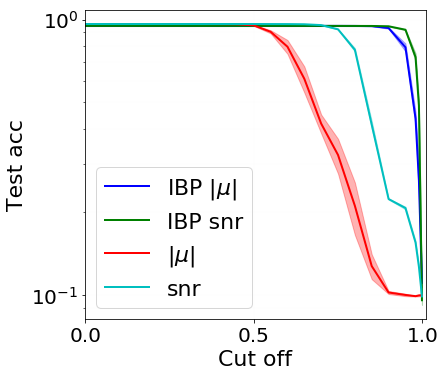

In [5]:
_ibp_ya_mean = np.mean(ya_ibp_all, axis=0)
_ibp_ya_std = np.std(ya_ibp_all, axis=0)
_ibp_yb_mean = np.mean(yb_ibp_all, axis=0)
_ibp_yb_std = np.std(yb_ibp_all, axis=0)
_ya_mean = np.mean(ya_all, axis=0)
_ya_std = np.std(ya_all, axis=0)
_yb_mean = np.mean(yb_all, axis=0)
_yb_std = np.std(yb_all, axis=0)

def test_error(ls):
    return 100*(1-np.array(ls))

fig_size = (6, 5)

set_y_axis = False

lw = 2

grid_color = '0.1'
grid_lw = 0.2

title_size = 16
label_size = 22
tick_size = 20
legend_size = 22

fig, ax = plt.subplots(1, 1, figsize=fig_size)

ax.plot(xs, _ibp_ya_mean,linewidth=lw, color='b')
ax.fill_between(xs,
               [x - y for x, y in zip(_ibp_ya_mean, _ibp_ya_std)],
               [x + y for x, y in zip(_ibp_ya_mean, _ibp_ya_std)],
               alpha=0.3, color='b')

ax.plot(xs, _ibp_yb_mean, linewidth=lw, color='g')
ax.fill_between(xs,
               [x - y for x, y in zip(_ibp_yb_mean, _ibp_yb_std)],
               [x + y for x, y in zip(_ibp_yb_mean, _ibp_yb_std)],
               alpha=0.3, color='g')

ax.plot(xs, _ya_mean,linewidth=lw, color='r')
ax.fill_between(xs,
               [x - y for x, y in zip(_ya_mean, _ya_std)],
               [x + y for x, y in zip(_ya_mean, _ya_std)],
               alpha=0.3, color='r')

ax.plot(xs, _yb_mean, linewidth=lw, color='c')
ax.fill_between(xs,
               [x - y for x, y in zip(_yb_mean, _yb_std)],
               [x + y for x, y in zip(_yb_mean, _yb_std)],
               alpha=0.3, color='c')

plt.grid(True, which="both", color=grid_color, linewidth=0.1, alpha=0.1)
ax.set_xlim(0.0, 0.5)
plt.yticks(fontsize=tick_size)
x_ticks = np.arange(0.0, 1.5, step=0.5)
plt.xticks(x_ticks, fontsize=tick_size)
plt.ticklabel_format(axis='y', style='sci')
ax = fig.gca()
ax.ticklabel_format(axis='y', style='sci', scilimits=(-1, 1))
#ax.set_yticklabels([])
plt.yscale('log')
plt.legend(["IBP $|\mu|$", 'IBP snr', '$|\mu|$', 'snr'], fontsize=legend_size, loc='lower left')
plt.tight_layout()
plt.xlabel("Cut off", fontsize=legend_size)
plt.ylabel("Test acc", fontsize=legend_size)
plt.xlim(0.0, 1.01)
plt.savefig("plots/weight_pruning_new.pdf", bbox_inches='tight')
plt.show()

In [27]:
with open('results/weight_pruning_5runs_new.pkl', 'wb') as input_file:
    pickle.dump({'ya_nnvi': ya_all,
                 'yb_nnvi': yb_all,
                 'ya_ibp': ya_ibp_all,
                 'yb_ibp': yb_ibp_all}, input_file)

In [15]:
with open('results/weight_pruning.pkl', 'wb') as input_file:
    pickle.dump({'ya_nnvi': ya,
                 'yb_nnvi': yb,
                 'ya_ibp': ya_ibp,
                 'yb_ibp': yb_ibp}, input_file)

In [ ]:
xs = np.append(0.05 * np.array(range(20)), np.array([0.98, 0.99, 0.999]))

In [3]:
with open('results/weight_pruning.pkl', 'rb') as input_file:
    d = pickle.load(input_file)
d.keys()

dict_keys(['ya_nnvi', 'yb_nnvi', 'ya_ibp', 'yb_ibp'])

In [10]:
ya = d['ya_nnvi']
yb = d['yb_nnvi']
ya_ibp = d['ya_ibp'][:len(xs)] # messed up the storing of the data...
yb_ibp = d['yb_ibp'][:len(xs)] # messed up the storing of the data...

In [12]:
ya == d['ya_ibp'][len(xs):] # yep

True

In [13]:
yb == d['yb_ibp'][len(xs):] # yep non-ibp has been appended to the list with ibp pruning results

True

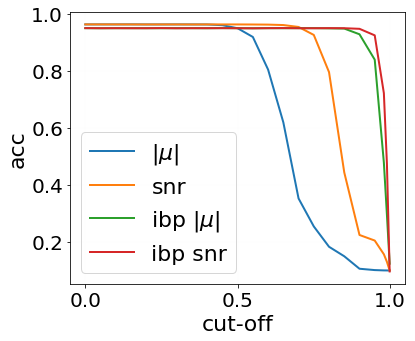

In [94]:
fig_size = (6, 5)
set_y_axis = False

lw = 2

grid_color = '0.1'
grid_lw = 0.2

title_size = 16
label_size = 22
tick_size = 20
legend_size = 22

fig, ax = plt.subplots(1, 1, figsize=fig_size)

plt.grid(True, which="both", color=grid_color, linewidth=0.1, alpha=0.1)
plt.yticks(fontsize=tick_size)
x_ticks = np.arange(0.0, 1.5, step=0.5)
plt.xticks(x_ticks, fontsize=tick_size)
plt.ticklabel_format(axis='y', style='sci')
ax = fig.gca()
ax.ticklabel_format(axis='y', style='sci', scilimits=(-1, 1))
ax.plot(xs, ya, linewidth=lw, label='$|\mu|$')
ax.plot(xs, yb, linewidth=lw, label='snr')
ax.plot(xs, ya_ibp, linewidth=lw, label='ibp $|\mu|$')
ax.plot(xs, yb_ibp, linewidth=lw, label='ibp snr')
plt.legend(fontsize=legend_size, loc='lower left')
plt.xlabel('cut-off', fontsize=legend_size)
plt.ylabel('acc', fontsize=legend_size)
plt.savefig('plots/weight_pruning.pdf', bbox_inches='tight')
plt.show()

# Z matrix

In [5]:
hidden_size = [100]
batch_size = 128
no_epochs = 600
ANNEAL_RATE=0.000
MIN_TEMP=0.1

tf.set_random_seed(12)
np.random.seed(1)

ibp_acc = np.array([])

coreset_size = 0
data_gen = MnistGenerator()
single_head=False
in_dim, out_dim = data_gen.get_dims()
x_testsets, y_testsets = [], []
task_id=0
    
tf.reset_default_graph()  
x_train, y_train, x_test, y_test = data_gen.task()
x_testsets.append(x_test)
y_testsets.append(y_test)

# Set the readout head to train
head = 0 if single_head else task_id
bsize = x_train.shape[0] if (batch_size is None) else batch_size

# Train network with maximum likelihood to initialize first model
if task_id == 0:
    ml_model = Vanilla_NN(in_dim, hidden_size, out_dim, x_train.shape[0])
    ml_model.train(x_train, y_train, task_id, 100, bsize)
    mf_weights = ml_model.get_weights()
    mf_variances = None
    mf_betas = None
    ml_model.close_session()

# Train on non-coreset data
mf_model = IBP_NN_prune(in_dim, hidden_size, out_dim, x_train.shape[0], 
                             num_ibp_samples=10, prev_means=mf_weights, 
                       prev_log_variances=mf_variances, prev_betas=mf_betas,alpha0=5.0, beta0=1.0,
                       learning_rate=0.00005, lambda_1=1.0, lambda_2=1.0, no_pred_samples=100,
                       name='ibp_wp_mnist_new')

mf_model.restore(os.path.join("logs", "graph_{}_task{}".format('ibp_wp_mnist_new', 0)))

Z = mf_model.sess.run(mf_model.Z, feed_dict={mf_model.x: x_test, mf_model.task_idx: task_id,
                                                 mf_model.training: False, mf_model.temp: 1.0})

mf_model.close_session()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch: 0001 cost= 0.415897005
Epoch: 0006 cost= 0.074962748
Epoch: 0011 cost= 0.036486464
Epoch: 0016 cost= 0.018615784
Epoch: 0021 cost= 0.009554423
Epoch: 0026 cost= 0.005482111
Epoch: 0031 cost= 0.001872123
Epoch: 0036 cost= 0.001100112
Epoch: 0041 cost= 0.000542177
Epoch: 0046 cost= 0.000375429
Epoch: 0051 cost= 0.007094237
Epoch: 0056 cost= 0.000214191
Epoch: 0061 cost= 0.000142287
Epoch: 0066 cost= 0.000304534
Epoch: 0071 cost= 0.000100214
Epoch: 0076 cost= 0.000063259
Epoch: 0081 cost= 0.000869675
Epoch: 0086 cost= 0.000065417
Epoch: 0091 cost= 0.000039322
Epoch: 0096 cost= 0.000025031
(1, ?, 100)
<unknown>
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
(1, ?, 100)
<unknown>
(1, ?, 100)
<unknown>
_Z: (1, ?, 100)
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring paramet

In [6]:
def lof(nu, probs=True):
    """Left ordering of binary matrix
    """
    if probs:
        Z = np.random.binomial(1, nu, nu.shape)
    else:
        Z = np.copy(nu)
    x = np.linspace(0, nu.shape[0]-1, nu.shape[0])
    xx, yy = np.meshgrid(x, x)
    exponent = nu.shape[0]-1-yy[:, :nu.shape[1]]
    magnitude = np.multiply(2**exponent, Z)
    full_Z = Z[:, np.sum(magnitude, axis=0).argsort()[::-1]] # reverse the sorting so that largest first!
    idy = np.flatnonzero(np.sum(full_Z, axis=0))
    non_zero_cols_Z= full_Z[:, idy]
    idx = np.flatnonzero(np.sum(non_zero_cols_Z, axis=1))
    return non_zero_cols_Z[idx, :]

_Z = lof(np.squeeze(Z[0]), probs=False)

/nfs/home/samuelk/anaconda2/envs/py36_tf_cpu/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in power
  # This is added back by InteractiveShellApp.init_path()
/nfs/home/samuelk/anaconda2/envs/py36_tf_cpu/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in multiply
  # This is added back by InteractiveShellApp.init_path()


In [11]:
np.squeeze(Z[0]).shape

(10000, 100)

In [13]:
Z[0]

array([[[3.6658740e-01, 3.8341838e-01, 4.2085710e-01, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [3.7674895e-01, 2.8279385e-01, 3.3417782e-01, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [6.1534905e-01, 4.1535163e-01, 5.3400165e-01, ...,
         0.0000000e+00, 8.9406971e-09, 0.0000000e+00],
        ...,
        [4.6225595e-01, 4.5252028e-01, 2.2136143e-01, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [5.2292103e-01, 5.1029086e-01, 4.2476040e-01, ...,
         0.0000000e+00, 8.9406971e-09, 0.0000000e+00],
        [4.0649453e-01, 4.9188432e-01, 4.4849801e-01, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00]]], dtype=float32)

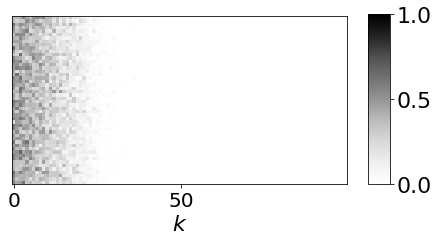

In [19]:
# The Sparse Z matrix is not well presented yet, hard to understand. Will a color bar + xtick +ytick help ?

set_y_axis = False

lw = 2

grid_color = '0.1'
grid_lw = 0.2

title_size = 16
label_size = 22
tick_size = 20
legend_size = 22

fig, ax = plt.subplots(1, 1)

imgplot = ax.imshow(np.squeeze(Z[0])[:50,:], cmap=plt.cm.Greys, vmin=0, vmax=1)
x_ticks = np.arange(0.0, 100, step=50)
plt.xticks(x_ticks, fontsize=tick_size)
plt.xlabel('$k$', fontsize=legend_size)
plt.yticks([], [])
cbar_ax = fig.add_axes([0.95, 0.21, 0.05, 0.59])
fig.colorbar(imgplot, cax=cbar_ax)
cbar_ax.tick_params(labelsize=legend_size) 
plt.savefig('plots/weight_pruning_Z.pdf', bbox_inches='tight')
fig.show()

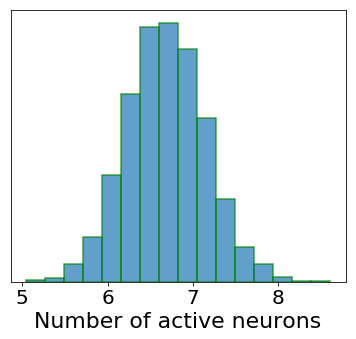

In [20]:
fig, ax = plt.subplots(1, 1, figsize=fig_size)
plt.hist(np.sum(np.squeeze(Z[0]), axis=1), 16, alpha=0.7, edgecolor='green', linewidth=1.5)
#plt.yticks(fontsize=tick_size)
x_ticks = np.arange(5.0, 9.0, step=1.0)
plt.xticks(x_ticks, fontsize=tick_size)
plt.yticks([])
plt.xlabel('Number of active neurons', fontsize=legend_size)
plt.savefig('plots/weight_pruning_active_neurons_hist.pdf', bbox_inches='tight')
fig.show()

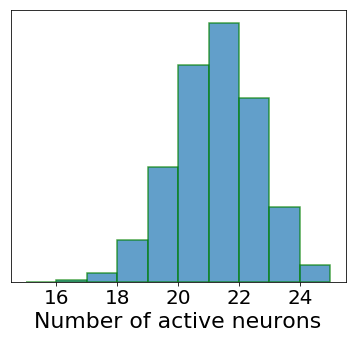

In [23]:
fig, ax = plt.subplots(1, 1, figsize=fig_size)
plt.hist(np.sum(np.asarray(np.squeeze(Z[0] > 0.1)).astype(int), axis=1),
         10, alpha=0.7, edgecolor='green', linewidth=1.5)
#plt.yticks(fontsize=tick_size)
#x_ticks = np.arange(5.0, 9.0, step=1.0)
plt.xticks(fontsize=tick_size)
plt.yticks([])
plt.xlabel('Number of active neurons', fontsize=legend_size)
plt.savefig('plots/weight_pruning_active_neurons_hist_cutoff_0.1.pdf', bbox_inches='tight')
fig.show()